In [24]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import pickle

# Dense Layer

In [25]:
class DenseLayer:
    def __init__(self, input_size, output_size, optimizer=None, seed=0):
        assert input_size > 0 and output_size > 0
        self.input_size = input_size
        self.output_size = output_size
        self.optimizer = optimizer
        np.random.seed(seed)
        # limit = np.sqrt(2 / input_size)  # Kaiming initialization
        limit = np.sqrt(6 / (input_size + output_size))  # Xavier initialization
        self.weights = np.random.uniform(-limit, limit, (output_size, input_size))
        self.biases = np.zeros((output_size, 1))

    def forward(self, input):
        self.input = input
        self.output = np.dot(self.weights, input) + self.biases
        return self.output
    
    
    def backward(self, output_gradients, learning_rate):
        self.input_gradients = np.dot(self.weights.T, output_gradients)
        weight_gradients = np.dot(output_gradients, self.input.T)
        bias_gradients = np.sum(output_gradients, axis=1, keepdims=True)
        
        if self.optimizer:
            self.optimizer.initialize(self.weights, self.biases)
            self.weights, _ = self.optimizer.update(self.weights, weight_gradients, self.biases, bias_gradients)
            _, self.biases = self.optimizer.update(self.weights, weight_gradients, self.biases, bias_gradients)
        else:
            self.weights -= learning_rate * weight_gradients
            self.biases -= learning_rate * bias_gradients
        
        return self.input_gradients
    
    def get_parameters(self):
        return self.weights, self.biases
    
    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases


# Normalization

In [26]:
class BatchNormalization:
    def __init__(self, input_size, momentum=0.9, epsilon=1e-5):
        self.input_size = input_size
        self.momentum = momentum
        self.epsilon = epsilon
        self.gamma = np.ones((input_size, 1))
        self.beta = np.zeros((input_size, 1))
        self.running_mean = np.zeros((input_size, 1))
        self.running_var = np.ones((input_size, 1))

    def forward(self, input, training=True):
        self.input = input
        if training:
            self.mean = np.mean(input, axis=1, keepdims=True)
            self.var = np.var(input, axis=1, keepdims=True)
            self.x_hat = (input - self.mean) / np.sqrt(self.var + self.epsilon)
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            self.x_hat = (input - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
        self.output = self.gamma * self.x_hat + self.beta
        return self.output
    
    def backward(self, output_gradients, learning_rate):
        N = self.input.shape[1]
        self.beta_gradients = np.sum(output_gradients, axis=1, keepdims=True)
        self.gamma_gradients = np.sum(output_gradients * self.x_hat, axis=1, keepdims=True)
        dx_hat = output_gradients * self.gamma
        dvar = np.sum(dx_hat * (self.input - self.mean) * -0.5 * (self.var + self.epsilon) ** -1.5, axis=1, keepdims=True)
        dmean = np.sum(dx_hat * -1 / np.sqrt(self.var + self.epsilon), axis=1, keepdims=True) + dvar * np.sum(-2 * (self.input - self.mean), axis=1, keepdims=True) / N
        self.input_gradients = dx_hat / np.sqrt(self.var + self.epsilon) + dvar * 2 * (self.input - self.mean) / N + dmean / N
        self.gamma -= learning_rate * self.gamma_gradients
        self.beta -= learning_rate * self.beta_gradients
        return self.input_gradients


# Activation

In [27]:
class ReLU:
    def forward(self, input):
        self.input = input
        self.output = np.maximum(input, 0)
        return self.output

    def backward(self, output_gradients, learning_rate):
        relu_grad = np.where(self.input > 0, 1, 0)
        return np.multiply(output_gradients, relu_grad)

# Dropout

In [28]:
class Dropout:
    def __init__(self, dropout_rate, seed=0):
        assert 0 <= dropout_rate < 1
        self.dropout_rate = dropout_rate
        self.seed = seed
        np.random.seed(seed)

    def forward(self, input, training=True):
        self.input = input
        if training:
            if self.dropout_rate == 1:
                return np.zeros_like(input)
            self.mask = (np.random.rand(*self.input.shape) > self.dropout_rate).astype(np.float32)
            self.output = np.multiply(self.input, self.mask) / (1 - self.dropout_rate)
            return self.output
        else:
            return input

    def backward(self, output_gradients, learning_rate):
        return np.multiply(output_gradients, self.mask) / (1 - self.dropout_rate)

# Adam Optimization

In [29]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

    def initialize(self, weights, biases):
        self.m = None
        self.v = None
        self.m_bias = None
        self.v_bias = None
        self.t = 1


    def update(self, weights, weight_gradients, biases, bias_gradients):
        if self.m is None:
            self.m = np.zeros_like(weights)
            self.v = np.zeros_like(weights)
        
        if self.m_bias is None:
            self.m_bias = np.zeros_like(biases)
            self.v_bias = np.zeros_like(biases)
            
        # Update weights
        self.m = self.beta1 * self.m + (1 - self.beta1) * weight_gradients
        self.v = self.beta2 * self.v + (1 - self.beta2) * np.square(weight_gradients)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        weights -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        
        # Update biases
        self.m_bias = self.beta1 * self.m_bias + (1 - self.beta1) * bias_gradients
        self.v_bias = self.beta2 * self.v_bias + (1 - self.beta2) * np.square(bias_gradients)
        m_hat_bias = self.m_bias / (1 - self.beta1 ** self.t)
        v_hat_bias = self.v_bias / (1 - self.beta2 ** self.t)
        biases -= self.learning_rate * m_hat_bias / (np.sqrt(v_hat_bias) + self.epsilon)

        self.t += 1
        # self.learning_rate *= 0.9
        
        return weights, biases

# Softmax

In [30]:
class Softmax:
    def forward(self, input):
        exp_values = np.exp(input - np.max(input, axis=0, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=0, keepdims=True)
        return self.output

    def backward(self, output_gradients, learning_rate):
        input_gradients = self.output * (output_gradients - np.sum(output_gradients * self.output, axis=0, keepdims=True))
        return input_gradients

# Model

In [31]:
class Model:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, input, training=True):
        for layer in self.layers:
            if isinstance(layer, (BatchNormalization, Dropout)):
                input = layer.forward(input, training=training)
            else:
                input = layer.forward(input)
        self.output = input
        return self.output

    def backward(self, output_gradients, learning_rate):
        for layer in reversed(self.layers):
            if hasattr(layer, 'backward'):
                output_gradients = layer.backward(output_gradients, learning_rate)

    def predict(self, input):
        return self.forward(input, training=False)

    def compute_loss(self, predictions, labels):
        m = labels.shape[1]
        log_likelihoods = -np.log(predictions[labels == 1])
        loss = np.sum(log_likelihoods) / m
        loss_grad = predictions - labels
        return loss, loss_grad
    
    def save(self, filename="model_1905088.pkl"):
        model_data = []
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                model_data.append((layer.weights, layer.biases))
        with open(filename, 'wb') as file:
            pickle.dump(model_data, file)

    def load(self, filename="model_1905088.pkl"):
        with open(filename, 'rb') as file:
            model_data = pickle.load(file)
        i = 0
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                layer.weights, layer.biases = model_data[i]
                layer.set_parameters(layer.weights, layer.biases)
                i += 1

In [32]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, val_f1_scores):
    epochs = np.arange(1, len(train_losses) + 1)
    
    # Loss vs Epoch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()

    # Accuracy vs Epoch
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()

    # F1-Score vs Epoch
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_f1_scores, label='Validation F1-Score', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [33]:
learning_rate = 0.001
optimizer = AdamOptimizer(learning_rate=learning_rate)

layers = [  
    DenseLayer(input_size=784, output_size=256, optimizer=optimizer), #3 hidden layers
    BatchNormalization(input_size=256),
    ReLU(),
    Dropout(dropout_rate=0.2),
    DenseLayer(input_size=256, output_size=128, optimizer=optimizer),
    BatchNormalization(input_size=128),
    ReLU(),
    Dropout(dropout_rate=0.2),
    DenseLayer(input_size=128, output_size=64, optimizer=optimizer),
    BatchNormalization(input_size=64),
    ReLU(),
    Dropout(dropout_rate=0.2),
    DenseLayer(input_size=64, output_size=10, optimizer=optimizer),
    Softmax()
]

# input_size = 784
# output_sizes = [256, 128, 64, 32, 16, 10]  # 5 hidden layers
# dropout_rate = 0.2
# layers = []

# for i, output_size in enumerate(output_sizes):
#     layers.append(DenseLayer(input_size=input_size, output_size=output_size, optimizer=optimizer))
#     input_size = output_size
#     if i < len(output_sizes) - 1:
#         layers.append(BatchNormalization(input_size=output_size))
#         layers.append(ReLU())
#         layers.append(Dropout(dropout_rate=dropout_rate))
#     else:
#         layers.append(Softmax())

model = Model(layers)

def train_model(model, x_train, y_train, x_val, y_val, epochs, batch_size):
    best_macro_f1 = 0
    best_model = None
    best_cm = None

    # metrics for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    
    for epoch in range(epochs):
        for i in range(0, x_train.shape[1], batch_size):
            batch_x = x_train[:, i:i + batch_size]
            batch_y = y_train[:, i:i + batch_size]
            output = model.forward(batch_x)
            loss, loss_grad = model.compute_loss(output, batch_y)
            model.backward(loss_grad, learning_rate=learning_rate)

        # Training loss and accuracy
        train_output = model.predict(x_train)
        train_loss, _ = model.compute_loss(train_output, y_train)
        train_predicted_labels = np.argmax(train_output, axis=0)
        train_true_labels = np.argmax(y_train, axis=0)
        train_accuracy = np.mean(train_predicted_labels == train_true_labels) * 100

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation set metrics
        val_loss, val_accuracy, val_macro_f1, val_cm = evaluate_model(model, x_val, y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_macro_f1)
        
        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Macro-F1: {val_macro_f1:.4f}')
        
        if val_macro_f1 > best_macro_f1:
            best_macro_f1 = val_macro_f1
            best_model = model
            best_cm = val_cm


    plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, val_f1_scores)
    
    print("Confusion Matrix for the Best F1-Validation Score Epoch:")
    print(best_cm)
    best_model.save()
    return best_model

def evaluate_model(model, x_test, y_test):
    predictions = model.predict(x_test)
    loss, _ = model.compute_loss(predictions, y_test)
    predicted_labels = np.argmax(predictions, axis=0)
    true_labels = np.argmax(y_test, axis=0)
    accuracy = np.mean(predicted_labels == true_labels) * 100
    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
    cm = confusion_matrix(true_labels, predicted_labels)
    return loss, accuracy, macro_f1, cm

# FashionMNIST Dataset

Epoch 1/30, Training Loss: 0.5299, Training Accuracy: 81.4000, Validation Loss: 0.5539, Validation Accuracy: 81.4750, Validation Macro-F1: 0.8211
Epoch 2/30, Training Loss: 0.4245, Training Accuracy: 86.2333, Validation Loss: 0.4573, Validation Accuracy: 85.6333, Validation Macro-F1: 0.8581
Epoch 3/30, Training Loss: 0.4584, Training Accuracy: 84.9750, Validation Loss: 0.5017, Validation Accuracy: 84.1417, Validation Macro-F1: 0.8451
Epoch 4/30, Training Loss: 0.3827, Training Accuracy: 88.3229, Validation Loss: 0.4322, Validation Accuracy: 87.3083, Validation Macro-F1: 0.8742
Epoch 5/30, Training Loss: 0.4114, Training Accuracy: 87.7146, Validation Loss: 0.4631, Validation Accuracy: 87.0167, Validation Macro-F1: 0.8717
Epoch 6/30, Training Loss: 0.4093, Training Accuracy: 88.9062, Validation Loss: 0.4771, Validation Accuracy: 87.7667, Validation Macro-F1: 0.8796
Epoch 7/30, Training Loss: 0.4052, Training Accuracy: 88.8083, Validation Loss: 0.4682, Validation Accuracy: 87.4083, Valida

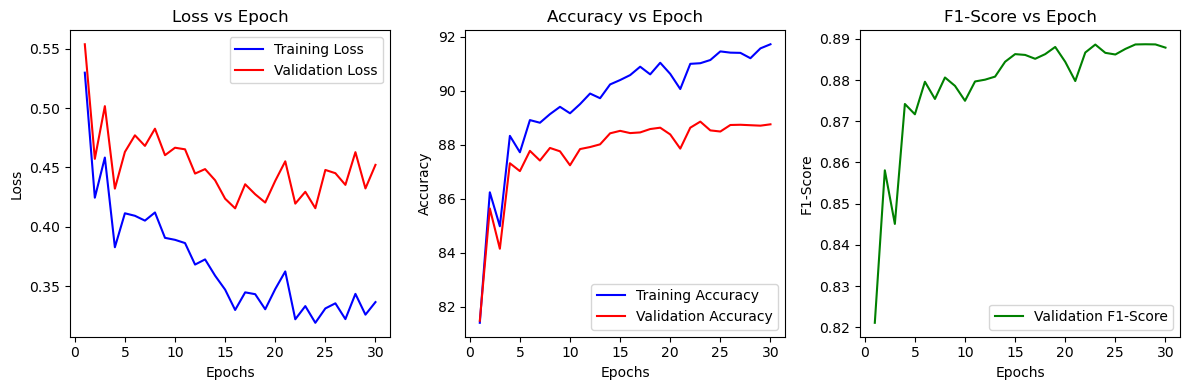

Confusion Matrix for the Best F1-Validation Score Epoch:
[[ 965    0   15   36    2    2  177    0   14    1]
 [   3 1137    2   23    2    0    6    0    0    0]
 [  15    0  951   15  134    1   94    0    5    0]
 [  17    5    5 1169   14    0   32    0    3    0]
 [   1    0   55   88 1003    1   55    0    7    0]
 [   1    0    0    0    0 1117    0   31    4   11]
 [  78    3   87   47   92    2  914    0    7    0]
 [   0    0    0    0    0   22    0 1161    1   30]
 [   4    0    6    6    8    6   19    0 1113    1]
 [   0    1    0    0    0   14    0   43    0 1116]]


In [34]:
def load_data(validation_split=0.2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=False)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=False)

    num_train = int((1 - validation_split) * len(train_dataset))
    train_data, val_data = torch.utils.data.random_split(train_dataset, [num_train, len(train_dataset) - num_train])

    x_train = np.array([np.array(data[0]) for data in train_data]).T
    y_train = np.eye(10)[np.array([data[1] for data in train_data])].T
    x_val = np.array([np.array(data[0]) for data in val_data]).T
    y_val = np.eye(10)[np.array([data[1] for data in val_data])].T
    x_test = np.array([np.array(data[0]) for data in test_dataset]).T
    y_test = np.eye(10)[test_dataset.targets.numpy()].T
    return x_train, y_train, x_val, y_val, x_test, y_test

x_train, y_train, x_val, y_val, x_test, y_test = load_data()
trained_model = train_model(model, x_train, y_train, x_val, y_val, epochs=30, batch_size=64)

In [35]:
# trained_model = Model(layers)
# trained_model.load()
test_loss, test_accuracy, test_macro_f1, test_cm = evaluate_model(trained_model, x_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Macro-F1: {test_macro_f1:.4f}')

Test Loss: 0.4876, Test Accuracy: 87.7600, Test Macro-F1: 0.8760
